# Calibration of a 2 theta arm with a ImagePad S140 detector

The aim of this document is to explain how to use pyFAI.goniometer for calibrating the position of the detector from the goniometer encoders.

Those data have been acquired at SOLEIL DiffAbs beamline in July 2020 by Cristian Mocuta using a imxpadS140 detector and LaB6 as calibrant. Eightyone images have been acquired with the detector arm moving between 7.5 and 140.5 degree with a step size of approx 1.7 degrees (and an offset of 15.5 degrees). The data are saved in a Nexus-file, the motor position is registered in the `actuator_1_1` dataset, and their 2D-diffraction images in another dataset called `data_06` inside the same nxs file.

A prior manual calibration (using `pyFAI-calib2`) has been performed on five images located in 2nd to 6th postìtions. Those images were the first with two rings. The control points extrated during this initial calibration has been used as a starting point for this calibration. Then more images have been added to make the model more robust.

The raw data files are available at: http://www.silx.org/pub/pyFAI/gonio/Soleil_diffabs/


# How can we consider the flat field files?

Initialization of the plotting library, matplotlib, to be used with the jupyter notebook

In [1]:
#%matplotlib inline
%matplotlib nbagg
import numpy
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import time, pyFAI

start_time = time.perf_counter()
print("Using pyFAI version", pyFAI.version)

import os
from silx.resources import ExternalResources

#Nota: Useful to configure a proxy if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.company.fr:3128"

downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/gonio", "PYFAI_DATA")
all_files = downloader.getdir("Soleil_diffabs.tar.bz2")
print([os.path.basename(i) for i in all_files])

Using pyFAI version 0.21.0-dev0
['Soleil_diffabs', 'picked_slice_4.npt', 'picked_slice_5.npt', 'picked_slice_2.npt', 'mask_soleil_imxpadS140_lab6.edf', 'picked_slice_5.poni', 'pyfai_calibrition_and_integration_soleil-Copy1.ipynb', 'picked_slice_2.poni', 'picked_slice_3.poni', 'picked_slice_1.npt', 'picked_slice_3.npt', 'picked_slice_4.poni', 'scan_0494_0001.nxs', 'picked_slice_1.poni']


In [2]:
#Loading of a few libraries

import random
import fabio
import pyFAI
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

import h5py

<IPython.core.display.Javascript object>


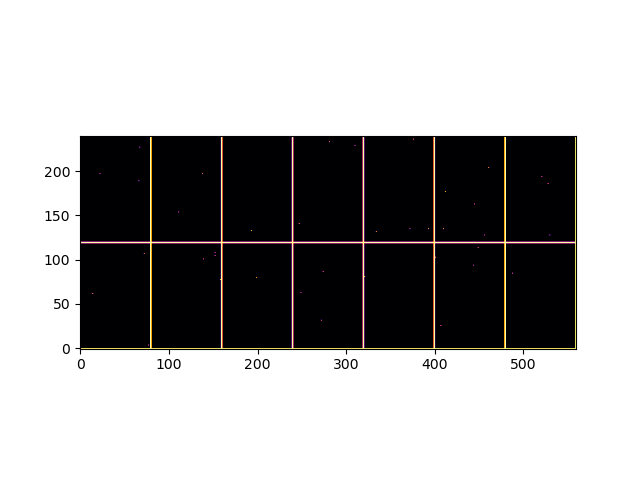

<AxesSubplot:>

In [3]:
nxs_file  = [i for i in all_files if i.endswith("scan_0494_0001.nxs")][0]
mask_file = [i for i in all_files if i.endswith("mask_soleil_imxpadS140_lab6.edf")][0]

mask = fabio.open(mask_file).data
#convert mask to boolean mask
mask = numpy.logical_or(mask, mask)

jupyter.display(mask)

In [4]:
#the energyShift was provided by the beamline scientist
energyShift = -0.060-.013-.0005*1.5


#extract the important data from the nxs file

with h5py.File(nxs_file,'r') as f:
    #groups = list(f.keys())
    group1 = f.get(list(f.keys())[0])
    print(group1.keys())
    positions = numpy.array(group1['scan_data/actuator_1_1'])
    image_files = numpy.array(group1['scan_data/data_06'])
    energy = numpy.array(group1['DIFFABS/d13-1-c03__op__mono/energy'])
    
    
energy = energy + energyShift
wavelength = pyFAI.units.hc / energy[0] * 1e-10 # convert to meters

print(energy, energyShift, wavelength, type(wavelength))


# here we prepare an array of indexes with which we will access the positions and respective images lateron
indexes_to_shuffle = numpy.arange(len(positions))

<KeysViewHDF5 ['DIFFABS', 'User', 'duration', 'end_time', 'proposal_number', 'proposal_title', 'run_cycle', 'scan_config', 'scan_data', 'start_time']>
[17.92647261] -0.07375 6.916262956318256e-11 <class 'numpy.float64'>


# Take care how you pick the peaks for the control point files

For choosing the control points one must be carful and register that on some images the same peak can be found but at different positions


<IPython.core.display.Javascript object>


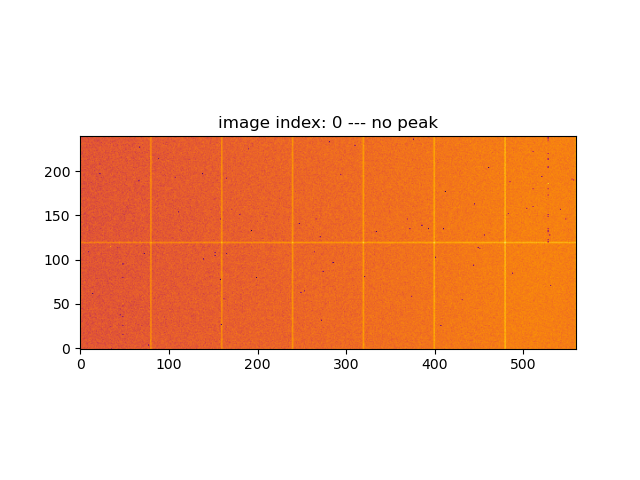

<IPython.core.display.Javascript object>


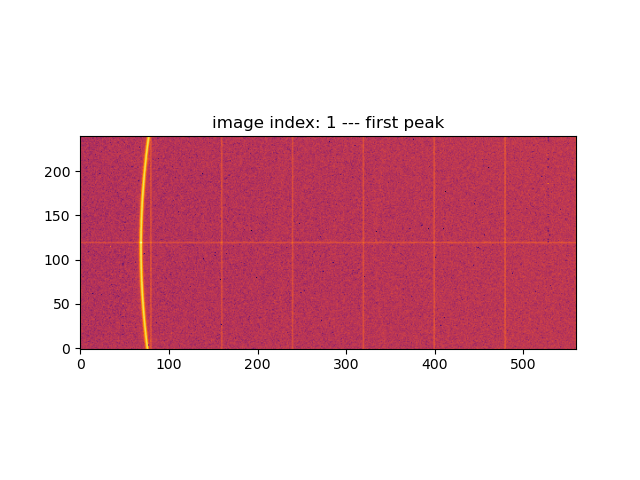

<IPython.core.display.Javascript object>


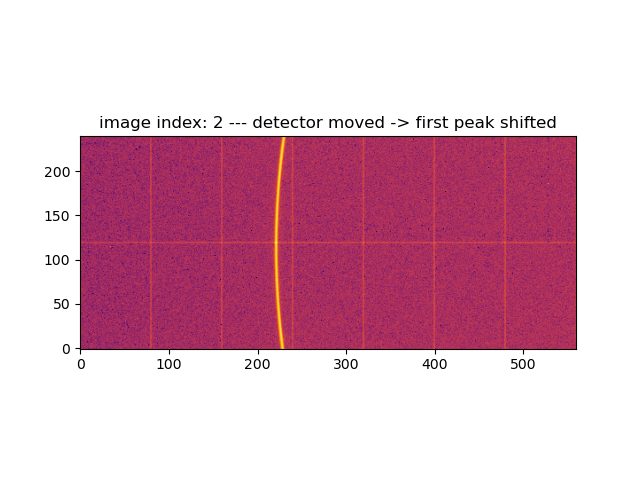

<IPython.core.display.Javascript object>


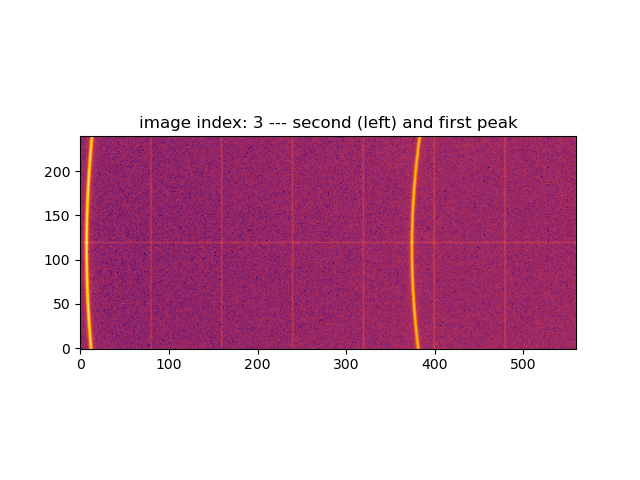

<IPython.core.display.Javascript object>


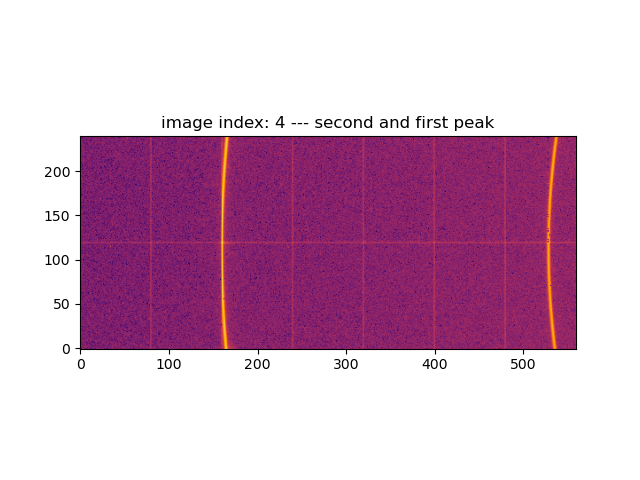

<IPython.core.display.Javascript object>


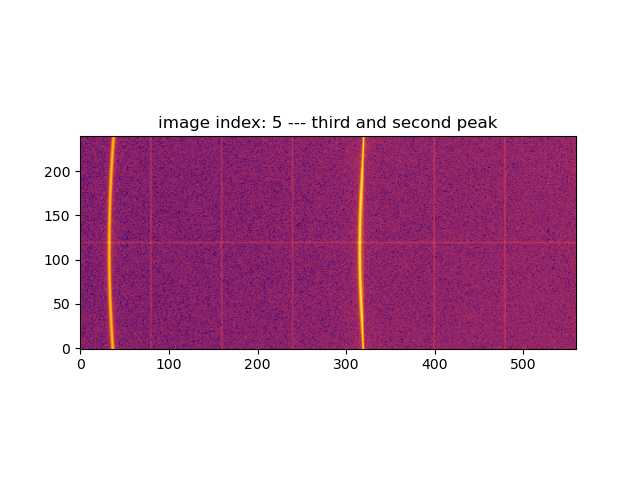

<IPython.core.display.Javascript object>


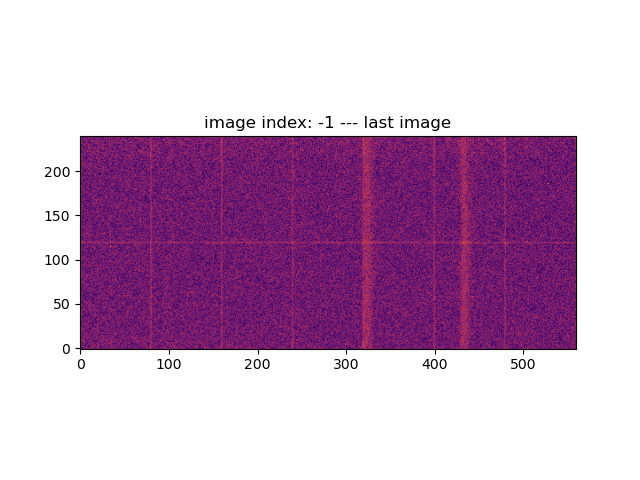

In [5]:
messages = ['no peak',
            'first peak',
            'detector moved -> first peak shifted',
            'second (left) and first peak',
            'second and first peak',
            'third and second peak',
            'last image',
]

print("For choosing the control points one must be carful and register that on some images the same peak can be found but at different positions")

for i_mess, index in enumerate([0, 1, 2, 3, 4,5, -1]):
    message = messages[i_mess]
    jupyter.display(image_files[index], label=f'image index: {index} --- {message}')
pass

# define detector and standard substance

In [6]:
imxpad = pyFAI.detector_factory("ImXPadS140")
imxpad.mask = mask
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = wavelength
LaB6

LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11

# Definition of the geometry transformation

This is the most difficult part to understand.

The next cell defines 2 functions, one for transforming the geometry and the other one to read the goniometer angle from the metadata

In [7]:
#Definition of the function reading the goniometer angle from the index array 'indexes_to_shuffle' that we built before

def get_angle(index, positions=positions):
    """Takes the basename (like del_65.0_0001p ) and returns the angle of the detector"""
    return positions[index]

print("angle:",get_angle(0))

angle: -8.003948505795


In [8]:
epsilon = numpy.finfo(numpy.float32).eps
# we can find the distance in one of the poni files
distance = 0.7125038520993905
# define var for offset
tth_offset = 15.5*numpy.pi/180.

#Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis. But the detector was rotated around 90 degrees, so it results in a rotition along rot1ℂ

_goniotrans = GeometryTransformation(param_names = ["dist", "poni1", "poni2",
                                                   "rot1_offset", "rot1_scale", "rot2"],
                                    dist_expr="dist",
                                    poni1_expr="poni1",
                                    poni2_expr="poni2",
                                    # rotation in "negative" ditection
                                    rot1_expr="-rot1_scale * pos - rot1_offset",
                                    rot2_expr="rot2",
                                    rot3_expr="pi/2")


_param = {"dist":distance,
         "poni1":-0.011,
         "poni2":0.178,
         "rot2":0.035,
         "rot1_offset": tth_offset,
         "rot1_scale": numpy.pi/180. , # rot2 is in radians, while the motor position is in degrees
         #"rot3": 90.
        }

_bounds = {"dist": (distance-0.15, distance+0.215),
          "rot2": (-0.25, 0.25),
          "rot1_offset": (tth_offset*0.9, tth_offset*1.1),
          "rot1_scale": (numpy.pi/180.-epsilon, numpy.pi/180.+epsilon) #strict bounds on the scale: we expect the gonio to be precise
         }


In [9]:
#Definition of the geometry refinement: the parameter order is the same as the param_names

gonioref = GoniometerRefinement(_param, #initial guess
                                bounds=_bounds,
                                pos_function=get_angle,
                                trans_function=_goniotrans,
                                detector=imxpad, wavelength=wavelength)

print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [10]:
#Let's populate the goniometer refinement object with all control point files:

npts = [i for i in all_files if i.endswith(".npt")]
npts.sort()

for fn in npts:
    cut = len('.npt')
    # cut as many latters as extension is long from filename string
    base = fn[:-cut]
    # we have written the arrayindex of the detector image we obtained control point and poni files from into the file name
    # e.g.: picked_slice_3.npt
    index = int(base.split('_')[-1])
    print(f'read file with index {index}')
    image = image_files[index]
    name = f'LaB6_slice_{index}'
    sg = gonioref.new_geometry(name, image=image, metadata=index, control_points=base+".npt",
                               #geometry=fn,
                               calibrant=LaB6
                              )
    print(sg.label, "Angle:", sg.get_position())
    sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    print(sg.geometry_refinement)
    print()

print("Filled refinement object:")
#print(gonioref)

read file with index 1
LaB6_slice_1 Angle: -6.342332658452
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.916263e-11m
SampleDetDist= 7.125039e-01m	PONI= -1.100000e-02, 1.780000e-01m	rot1=-0.159831  rot2= 0.035000  rot3= 1.570796 rad
DirectBeamDist= 722.145mm	Center: x=2252.771, y=109.769 pix	Tilt=9.373 deg  tiltPlanRotation= 12.408 deg

read file with index 2
LaB6_slice_2 Angle: -4.679976799598
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.916263e-11m
SampleDetDist= 7.125039e-01m	PONI= -1.100000e-02, 1.780000e-01m	rot1=-0.188845  rot2= 0.035000  rot3= 1.570796 rad
DirectBeamDist= 725.845mm	Center: x=2416.734, y=110.764 pix	Tilt=11.002 deg  tiltPlanRotation= 10.565 deg

read file with index 3
LaB6_slice_3 Angle: -3.017268935268
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.916263e-11m
SampleDetDist= 7.125039e-01m	PONI= -1.100000e-02, 1.780000e-01m	rot1=-0.217865  rot2= 0.035000  rot3= 1.570796 rad
DirectBeamDist= 730

<IPython.core.display.Javascript object>


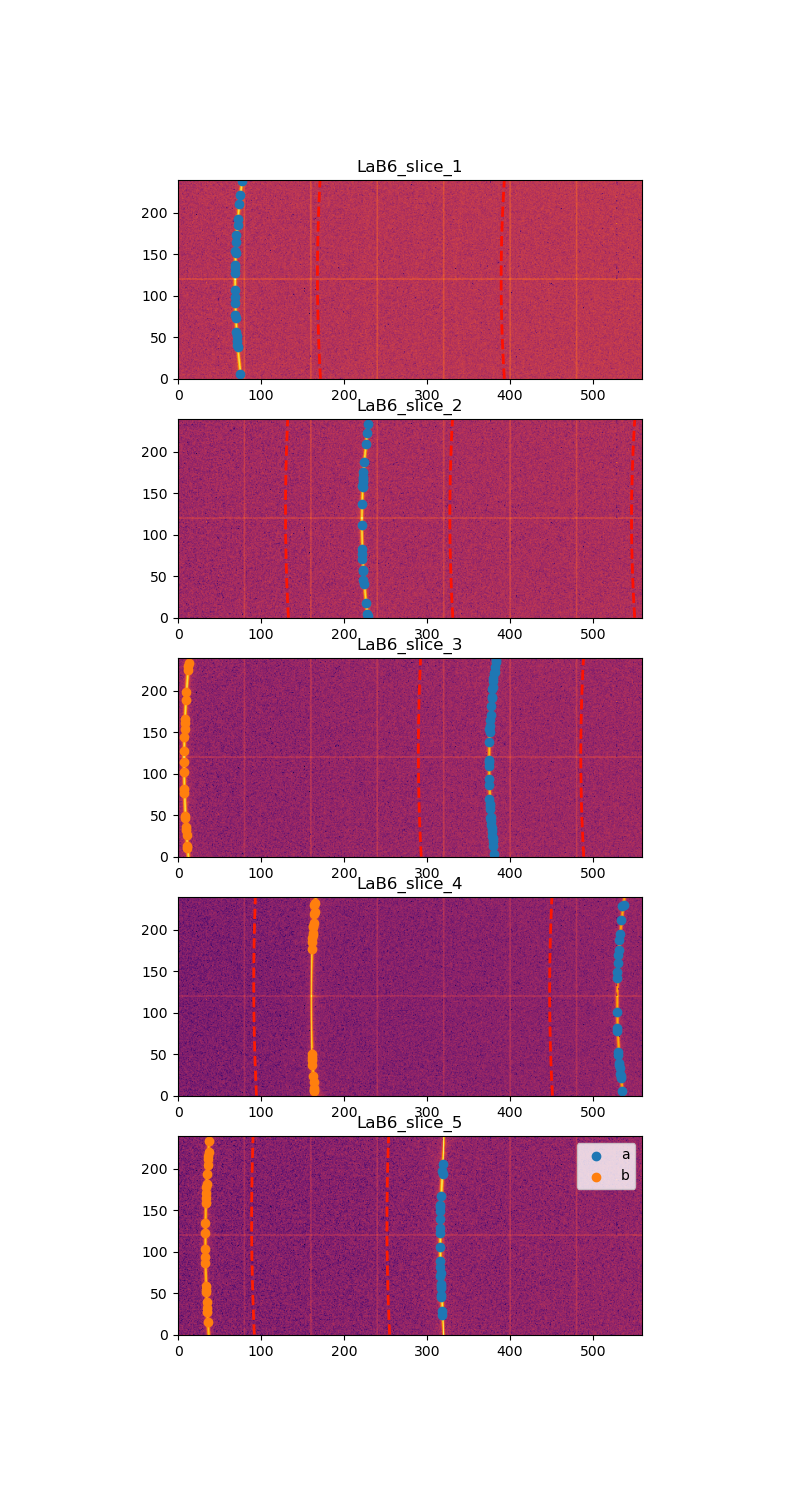

In [11]:
#Display all images with associated calibration:
nimg = len(gonioref.single_geometries)
fig,ax = subplots(nimg, 1, figsize=(8,nimg*3))
for i, sg in enumerate(gonioref.single_geometries.values()):
    jupyter.display(sg=sg, ax=ax[i])
pass

Cost function before refinement: 0.05147682754832252
[ 0.71250385 -0.011       0.178       0.27052603  0.01745329  0.035     ]
     fun: 2.6138599401319755e-09
     jac: array([-1.34264118e-08, -6.72734760e-09, -5.26127490e-07, -4.17470898e-07,
       -1.61284823e-06, -7.38141306e-09])
 message: 'Optimization terminated successfully'
    nfev: 484
     nit: 68
    njev: 68
  status: 0
 success: True
       x: array([ 0.71056499,  0.0233506 , -0.00498698,  0.29690286,  0.01745341,
       -0.01155855])
Cost function after refinement: 2.6138599401319755e-09
GonioParam(dist=0.7105649907909554, poni1=0.023350595089794937, poni2=-0.004986980734666472, rot1_offset=0.2969028609729177, rot1_scale=0.017453411729232846, rot2=-0.011558552261624937)
maxdelta on: poni2 (2) 0.178 --> -0.004986980734666472


<IPython.core.display.Javascript object>


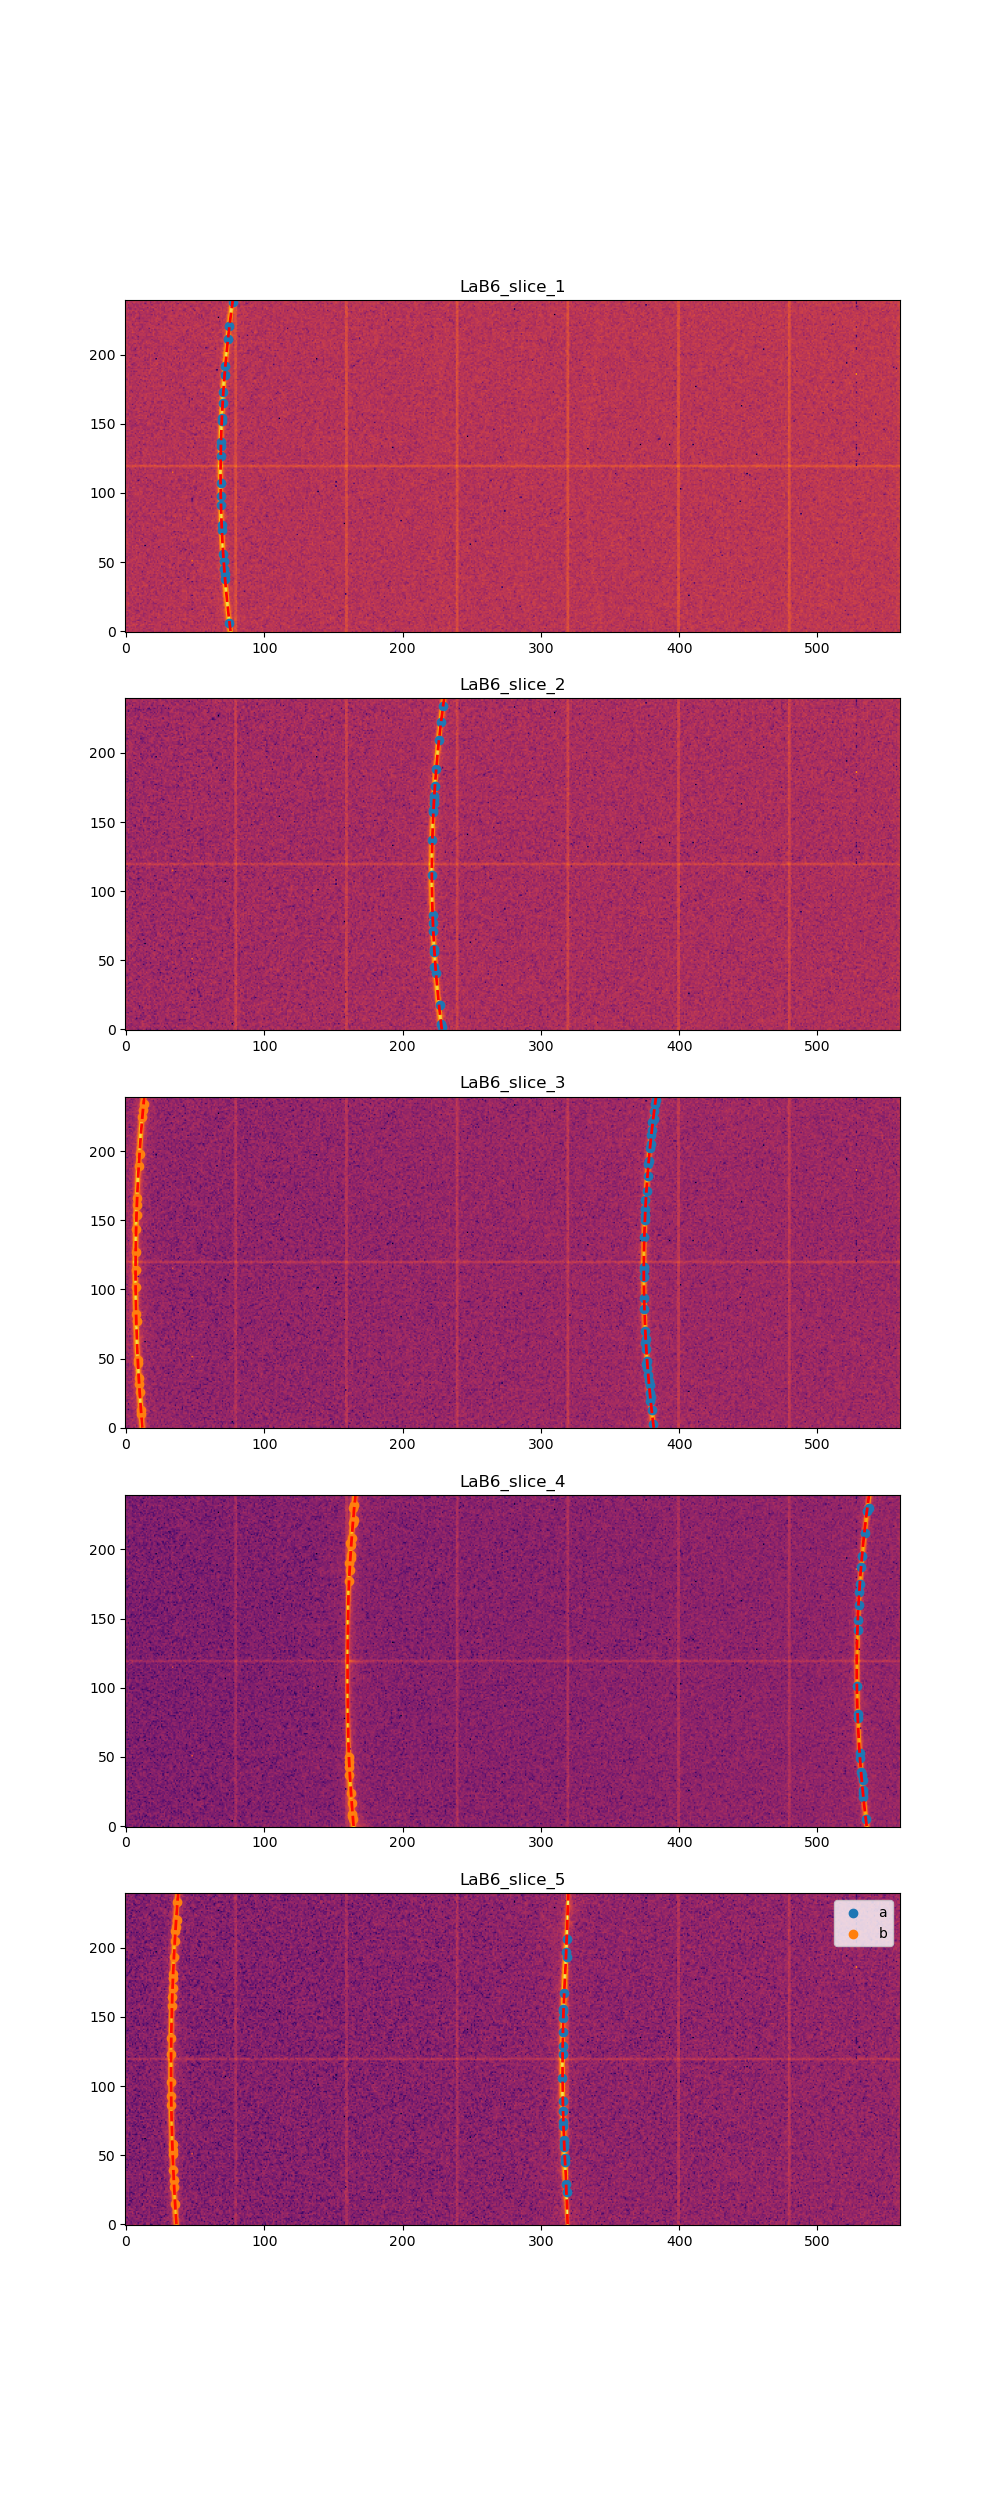

In [12]:
# Initial refinement of the goniometer model with 5 dof
gonioref.refine2()

nimg = len(gonioref.single_geometries)
fig,ax = subplots(nimg, 1, figsize=(10,nimg*5))

for i, sg in enumerate(gonioref.single_geometries.values()):
    sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=ax[i])
pass

In [13]:
# This function adds new images to the pool of data used for the refinement.
# A set of new control points are extractred and a refinement step is performed at each iteration
# The last image of the serie is displayed

def optimize_with_new_images(indexes, pts_per_deg=1):
    """
    we take an array of numbers being the indexes of detector positions and images
    """
    sg = None
    for index in indexes:
        image = image_files[index]
        name = f'LaB6_slice_{index}'
        # leaves out already loaded images
        if name in gonioref.single_geometries:
            continue
        sg = gonioref.new_geometry(name, image=image, metadata=index,
                                   calibrant=LaB6)
        print(f"Frame {index} extracted {sg.extract_cp(pts_per_deg=pts_per_deg)}")
    print("*"*50)
    gonioref.refine2()
    if sg:
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
        jupyter.display(sg=sg)

Frame 8 extracted ControlPoints instance containing 3 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 3 groups of points:
# c ring 2: 27 points
# d ring 3: 27 points
# e ring 4: 21 points
Frame 0 extracted ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 0 groups of points:
Frame 10 extracted ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 1 groups of points:
# f ring 4: 21 points
Frame 6 extracted ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 2 groups of points:
# g ring 1: 36 points
# h ring 2: 30 points
Frame 11 extracted ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 2 groups of points:
#

<IPython.core.display.Javascript object>


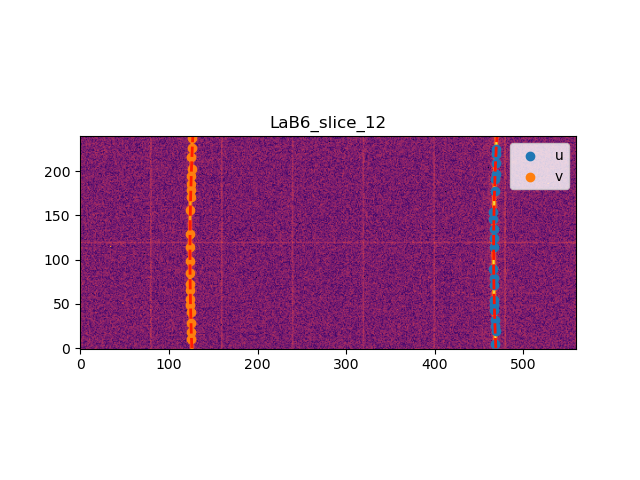

In [14]:
# Append first 15 images

images_30_40 = indexes_to_shuffle[:15]
random.shuffle(images_30_40)
optimize_with_new_images(images_30_40, pts_per_deg=3)

Frame 33 extracted ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 5 groups of points:
# w ring 28: 12 points
# x ring 29: 12 points
# y ring 30: 12 points
# z ring 31: 12 points
#aa ring 32: 12 points
Frame 29 extracted ControlPoints instance containing 3 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 3 groups of points:
#ab ring 23: 12 points
#ac ring 24: 12 points
#ad ring 26: 12 points
Frame 43 extracted ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 6 groups of points:
#ae ring 45: 12 points
#af ring 46: 12 points
#ag ring 47: 12 points
#ah ring 48: 12 points
#ai ring 49: 12 points
#aj ring 50: 12 points
Frame 61 extracted ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 5 

Frame 47 extracted ControlPoints instance containing 7 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 7 groups of points:
#fy ring 51: 12 points
#fz ring 52: 12 points
#ga ring 53: 12 points
#gb ring 54: 12 points
#gc ring 55: 2 points
#gd ring 56: 12 points
#ge ring 57: 12 points
Frame 18 extracted ControlPoints instance containing 3 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 3 groups of points:
#gf ring 10: 15 points
#gg ring 11: 15 points
#gh ring 12: 15 points
Frame 76 extracted ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 5 groups of points:
#gi ring 99: 12 points
#gj ring 100: 12 points
#gk ring 101: 12 points
#gl ring 102: 12 points
#gm ring 103: 12 points
Frame 38 extracted ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.9162629

Frame 17 extracted ControlPoints instance containing 4 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 4 groups of points:
#lq ring 9: 15 points
#lr ring 10: 15 points
#ls ring 11: 15 points
#lt ring 12: 15 points
Frame 21 extracted ControlPoints instance containing 4 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 4 groups of points:
#lu ring 13: 15 points
#lv ring 14: 15 points
#lw ring 15: 15 points
#lx ring 16: 15 points
Frame 41 extracted ControlPoints instance containing 6 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 6 groups of points:
#ly ring 41: 12 points
#lz ring 42: 12 points
#ma ring 43: 12 points
#mb ring 44: 12 points
#mc ring 45: 12 points
#md ring 46: 12 points
Frame 48 extracted ControlPoints instance containing 7 group of point:
LaB6 Calibrant with 121 reflections at wavelength 6.916262956318256e-11
Containing 7 g

<IPython.core.display.Javascript object>


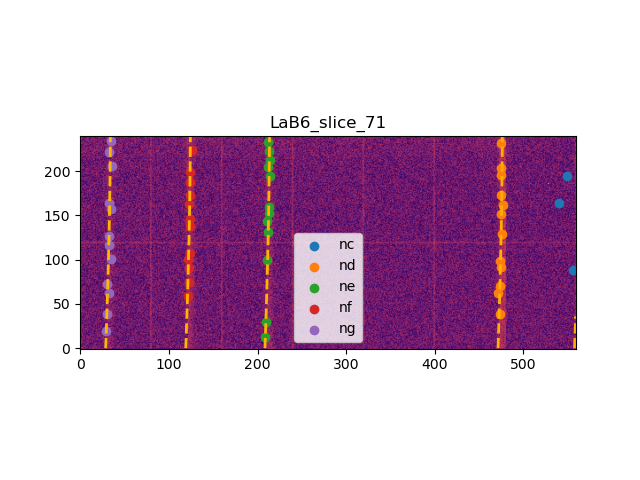

In [15]:
# Append all other images

random.shuffle(indexes_to_shuffle)
optimize_with_new_images(indexes_to_shuffle, pts_per_deg=3)

print some rings
Total number of images: 81


<IPython.core.display.Javascript object>


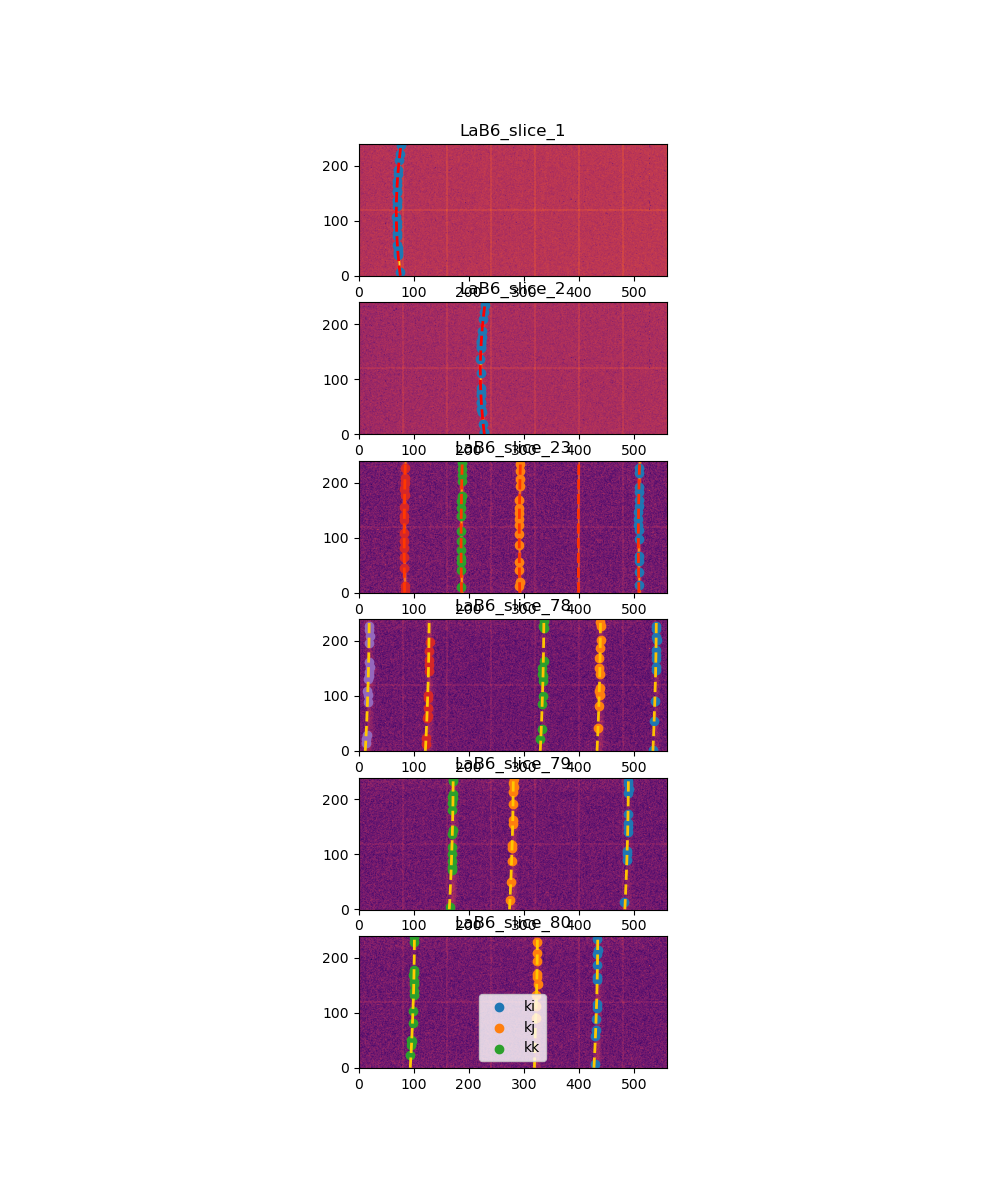

In [16]:
# Check the calibration of the first and the last image with rings
def func_print_some_rings(gonioref):
    print("print some rings")

    print("Total number of images:", len(gonioref.single_geometries) )

    fig,ax  = subplots(6, 1, figsize=(10,12))
    for idx,lbl in enumerate([f'LaB6_slice_{1}', f'LaB6_slice_{2}', f'LaB6_slice_{23}', f'LaB6_slice_{78}', f'LaB6_slice_{79}', f'LaB6_slice_{80}']):
        sg = gonioref.single_geometries[lbl]
        if sg.control_points.get_labels():
            sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
        jupyter.display(sg=sg, ax=ax[idx])
        
func_print_some_rings(gonioref)

In [17]:
# Final pass of reforginement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine2("slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)
gonioref.refine2("simplex")

Cost function before refinement: 5.661264947056637e-08
[ 0.71058734  0.02338876 -0.00500139  0.29689736  0.01745329 -0.01152923]
     fun: 5.60100276886388e-08
     jac: array([-1.18415443e-08,  8.91635690e-07, -9.25781750e-08, -6.74482321e-08,
       -2.58219654e-06, -2.06795423e-07])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.7105945 ,  0.02357004, -0.00501034,  0.2969102 ,  0.01745322,
       -0.01067385])
Cost function after refinement: 5.60100276886388e-08
GonioParam(dist=0.7105945031942115, poni1=0.023570035166269755, poni2=-0.00501034181145751, rot1_offset=0.29691020398130985, rot1_scale=0.017453217584074573, rot2=-0.010673848612124597)
maxdelta on: rot2 (5) -0.011529232967622705 --> -0.010673848612124597
Cost function before refinement: 5.60100276886388e-08
[ 0.7105945   0.02357004 -0.00501034  0.2969102   0.01745322 -0.01067385]
 final_simplex: (array([[ 0.7089986 ,  0.02153983, -0.016966

array([ 0.7089986 ,  0.02153983, -0.01696634,  0.31381372,  0.01745254,
       -0.00856555])

In [18]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)

multigeo = gonioref.get_mg(angles)
integration_range = (4, 135)
multigeo.radial_range = integration_range
print(multigeo)
positions[-1]

MultiGeometry integrator with 81 geometries on (4, 135) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


124.9965143891

In [19]:
# Calculate the optimal number of point for integration
over = 3
npt = int(over * numpy.deg2rad(max(multigeo.radial_range) - min(multigeo.radial_range)) /
          numpy.arctan2(imxpad.pixel1, gonioref.nt_param(*gonioref.param).dist))
print("Number of bins: %s"%npt)

Number of bins: 37408


<IPython.core.display.Javascript object>


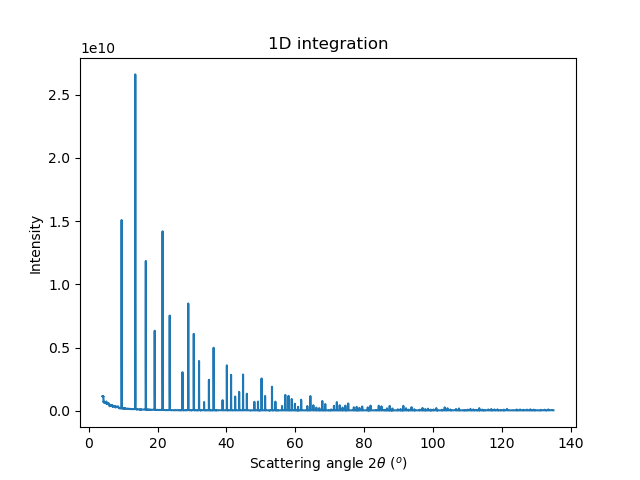

In [20]:
# Integrate the whole set of images in a single run:

res = multigeo.integrate1d(images, npt)
jupyter.plot1d(res)
pass

In [21]:
# Save the goniometer configuration with 1 angle

gonioref.save("soleil_v1.json")

In [22]:
gonioref.sload("soleil_v1.json"), gonioref

(GoniometerRefinement with 0 geometries labeled: .,
 GoniometerRefinement with 81 geometries labeled: LaB6_slice_1, LaB6_slice_2, LaB6_slice_3, LaB6_slice_4, LaB6_slice_5, LaB6_slice_8, LaB6_slice_0, LaB6_slice_10, LaB6_slice_6, LaB6_slice_11, LaB6_slice_13, LaB6_slice_14, LaB6_slice_9, LaB6_slice_7, LaB6_slice_12, LaB6_slice_33, LaB6_slice_29, LaB6_slice_43, LaB6_slice_61, LaB6_slice_79, LaB6_slice_32, LaB6_slice_46, LaB6_slice_25, LaB6_slice_24, LaB6_slice_57, LaB6_slice_58, LaB6_slice_65, LaB6_slice_54, LaB6_slice_67, LaB6_slice_75, LaB6_slice_28, LaB6_slice_19, LaB6_slice_23, LaB6_slice_35, LaB6_slice_62, LaB6_slice_72, LaB6_slice_40, LaB6_slice_36, LaB6_slice_64, LaB6_slice_70, LaB6_slice_34, LaB6_slice_44, LaB6_slice_74, LaB6_slice_51, LaB6_slice_50, LaB6_slice_47, LaB6_slice_18, LaB6_slice_76, LaB6_slice_38, LaB6_slice_55, LaB6_slice_16, LaB6_slice_52, LaB6_slice_30, LaB6_slice_22, LaB6_slice_60, LaB6_slice_45, LaB6_slice_56, LaB6_slice_69, LaB6_slice_15, LaB6_slice_31, LaB6_sli

In [23]:
#Can the refinement be improved by freeing another degree of freedom ? what about rot1 ?

goniotrans2 = GeometryTransformation(param_names = ["dist", "poni1", "poni2",
                                                    "rot1_offset", "rot1_scale",
                                                   "rot2", "rot2_scale",],
                                     dist_expr="dist",
                                     poni1_expr="poni1",
                                     poni2_expr="poni2",
                                     # rotation in "negative" ditection
                                     rot1_expr="-rot1_scale * pos - rot1_offset",
                                     rot2_expr="-rot2_scale * pos - rot2",
                                     rot3_expr="pi/2")




param2 = (gonioref.nt_param(*gonioref.param))._asdict()
param2["rot2_scale"] = 0 # numpy.pi/180.


gonioref2 = GoniometerRefinement(param2,
                                 pos_function = get_angle,
                                 trans_function=goniotrans2,
                                 detector=imxpad,
                                 wavelength=wavelength)
gonioref2.single_geometries = gonioref.single_geometries.copy()

print(gonioref2.chi2(), gonioref.chi2())
gonioref2.refine2()
#gonioref2.save("ROBL_v2.json")


2.782059407001955e-07 5.470897305142059e-08
Cost function before refinement: 2.782059407001955e-07
[ 0.7089986   0.02153983 -0.01696634  0.31381372  0.01745254 -0.00856555
  0.        ]
     fun: 5.5708447525641924e-08
     jac: array([-1.74918786e-08, -9.13192557e-08, -1.16159781e-06, -8.27202828e-07,
       -4.29950251e-05, -3.81020464e-08,  6.07276030e-07])
 message: 'Optimization terminated successfully'
    nfev: 134
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 7.09036135e-01,  1.35566382e-02, -1.69725147e-02,  3.13804737e-01,
        1.74515618e-02, -2.65423099e-03,  1.45916563e-04])
Cost function after refinement: 5.5708447525641924e-08
GonioParam(dist=0.7090361353100382, poni1=0.013556638191764822, poni2=-0.016972514661117537, rot1_offset=0.3138047365365944, rot1_scale=0.017451561792521712, rot2=-0.002654230985330557, rot2_scale=0.0001459165626460663)
maxdelta on: poni1 (1) 0.02153982511603266 --> 0.013556638191764822


array([ 7.09036135e-01,  1.35566382e-02, -1.69725147e-02,  3.13804737e-01,
        1.74515618e-02, -2.65423099e-03,  1.45916563e-04])

print some rings
Total number of images: 81


<IPython.core.display.Javascript object>


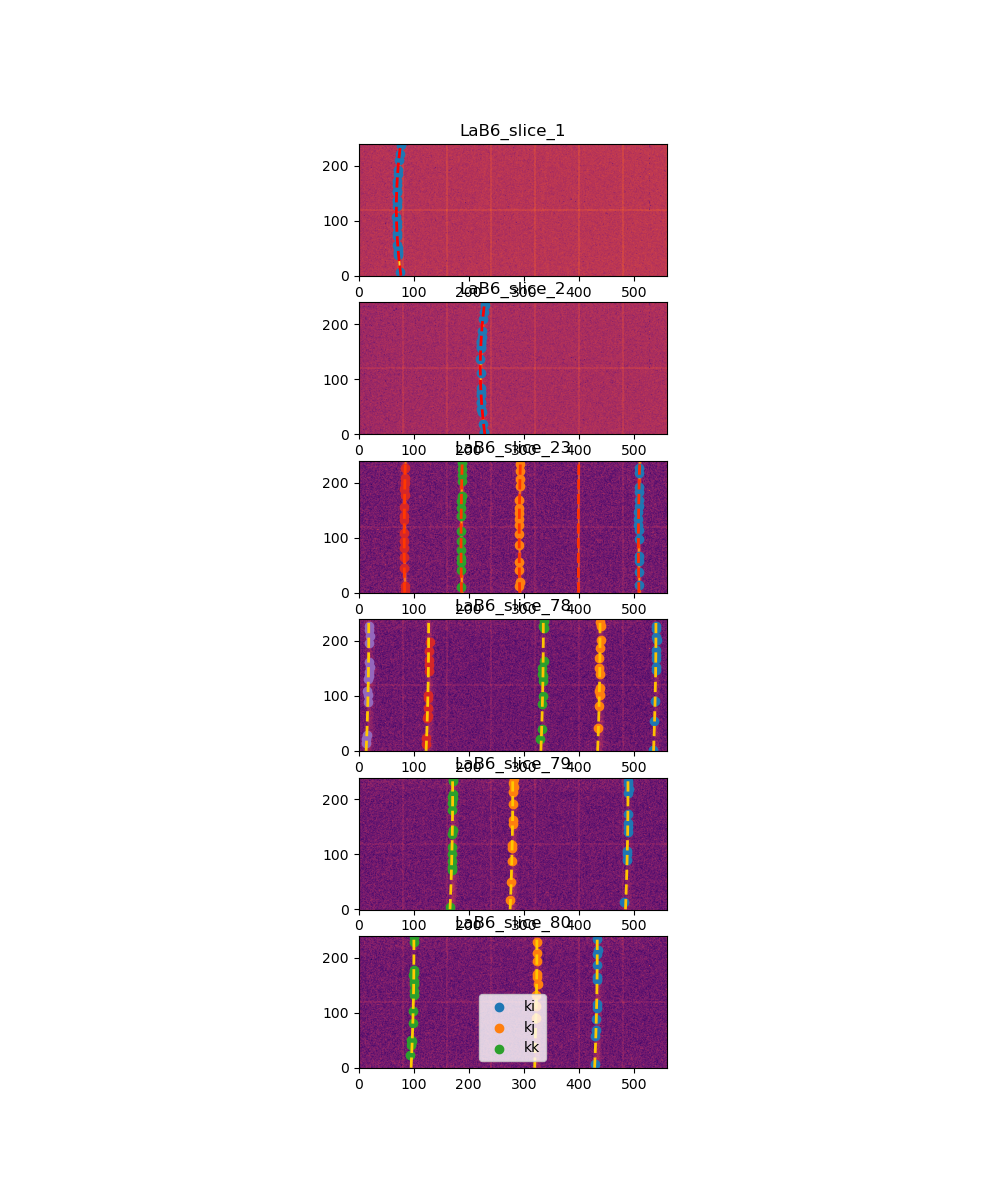

In [24]:
func_print_some_rings(gonioref2)

In [25]:
#Create a MultiGeometry integrator from the refined geometry and display the integrated image:

multigeo2 = gonioref2.get_mg(angles)
multigeo2.radial_range = integration_range

res2 = multigeo2.integrate1d(images, npt)

<IPython.core.display.Javascript object>


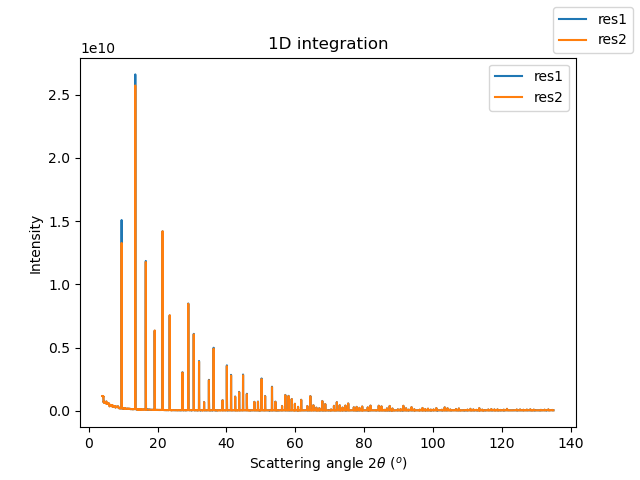

In [26]:
#res = multigeo.integrate1d(images, npt)
fig, ax = plt.subplots()
jupyter.plot1d(res, ax=ax, label="res1")
jupyter.plot1d(res2, ax=ax, label="res2")
fig.legend()
pass

<IPython.core.display.Javascript object>


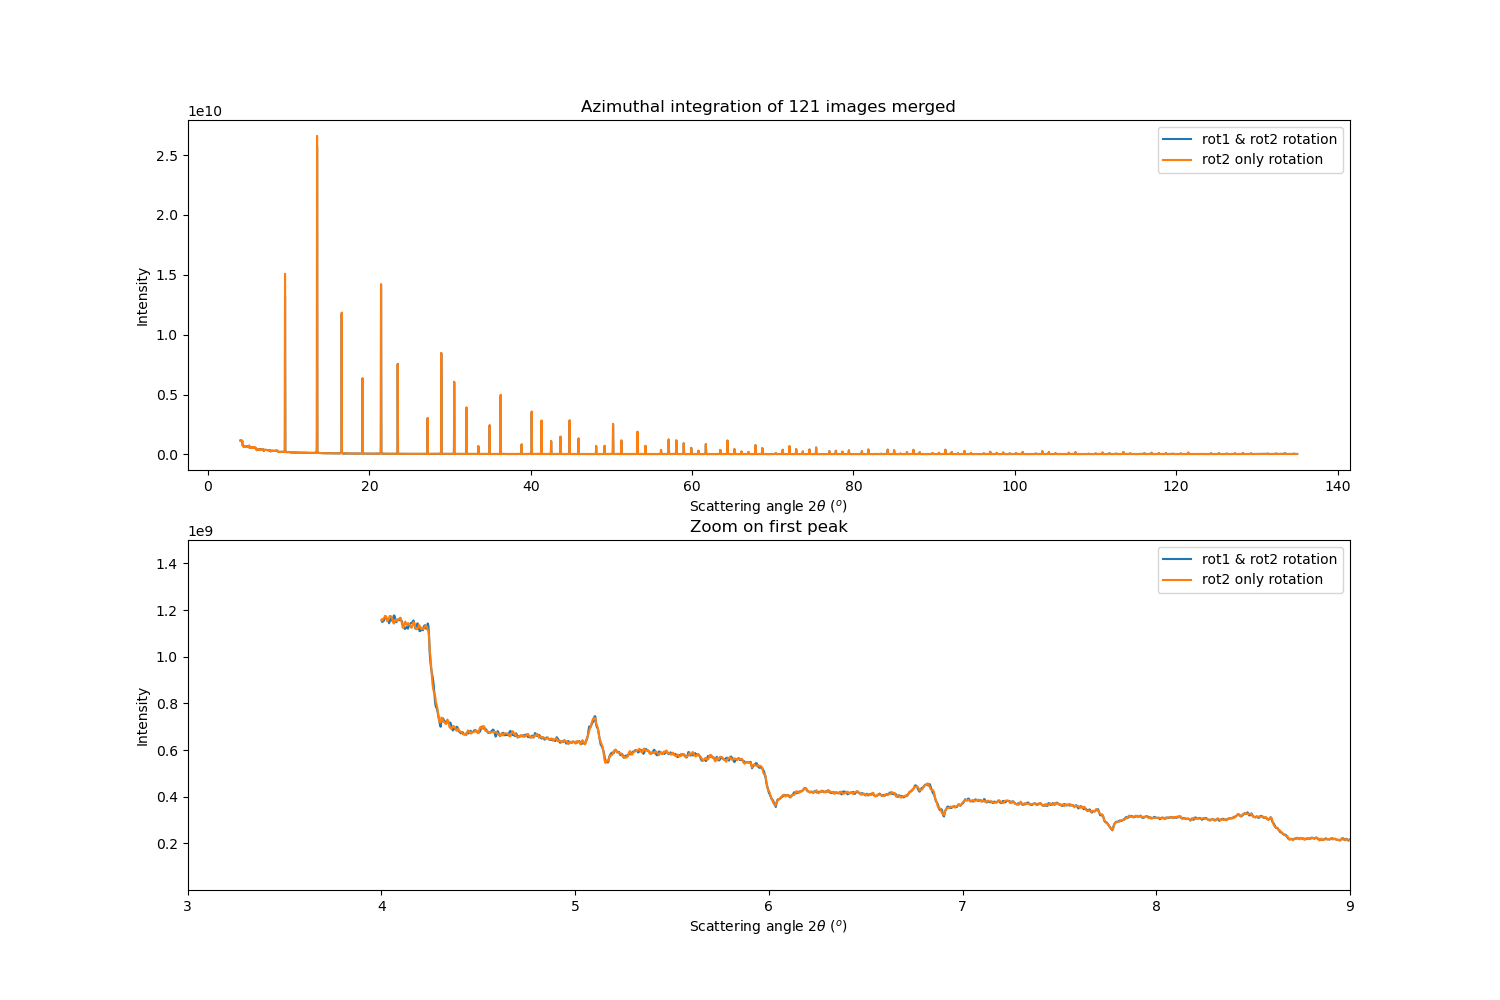

In [27]:
#Display the 2 curves with a zoom
fig,ax = subplots(2, 1, figsize=(15,10))
ax[0].plot(*res2, label="rot1 & rot2 rotation")
ax[0].plot(*res, label="rot2 only rotation")
ax[0].set_xlabel(res.unit.label)
ax[0].set_ylabel("Intensity")
ax[0].set_title("Azimuthal integration of 121 images merged")
ax[0].legend()

ax[1].plot(*res2, label="rot1 & rot2 rotation")
ax[1].plot(*res, label="rot2 only rotation")
ax[1].set_xlabel(res.unit.label)
ax[1].set_ylabel("Intensity")
ax[1].set_xlim(3.0, 9)
ax[1].set_ylim(0.5, 1.5e9)
ax[1].set_title("Zoom on first peak")
ax[1].legend()
pass

<IPython.core.display.Javascript object>


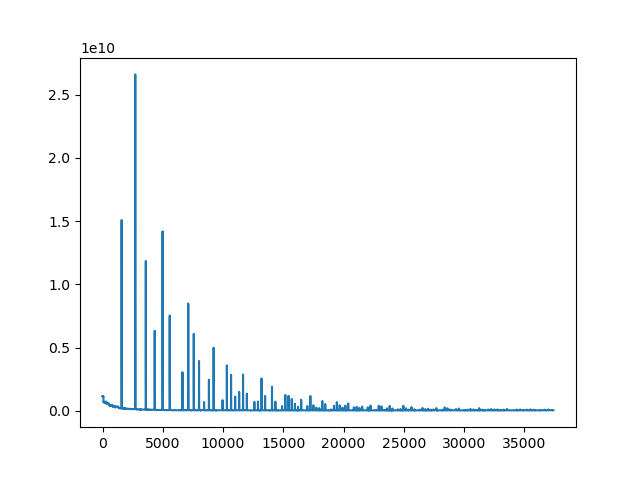

In [28]:
fig, ax = plt.subplots()
ax.plot(res.intensity)

<IPython.core.display.Javascript object>


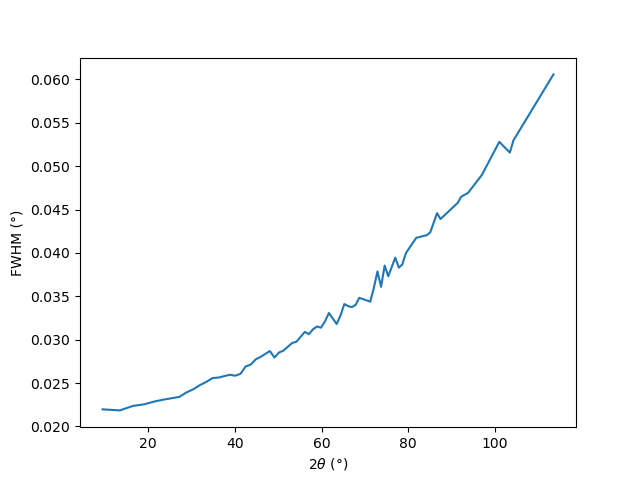

Text(0, 0.5, 'FWHM (°)')

In [29]:
# Line profile function...
#Peak profile
from scipy.signal import find_peaks
def calc_fwhm(res, width=None, prominence=None):
    peaks = find_peaks(res.intensity, width=width, prominence=prominence, rel_height=0.5 )
    idx = numpy.arange(len(res.radial))
    peak_pos = numpy.interp(peaks[0], idx, res.radial)
    left = numpy.interp(peaks[1]["left_ips"], idx, res.radial)
    right = numpy.interp(peaks[1]["right_ips"], idx, res.radial)
    return peak_pos, right-left
fig,ax = subplots()
ax.plot(*calc_fwhm(res,  width=(6,20), prominence=1.5e8))
ax.set_xlabel(r"$2\theta$ (°)")
ax.set_ylabel("FWHM (°)")


In [30]:
#Fit against Caglioti's formula:
# FWHM^2 = Utan2 + Vtan + W
tth_deg, FWHM_deg = calc_fwhm(res2, width=(6,20), prominence=1.5e8)

def model_Caglioti(tth_deg, U, V, W):
    tantheta = numpy.tan(numpy.deg2rad(tth_deg)/2.0)
    FWHM2 = U*tantheta*tantheta + V*tantheta + W
    return numpy.rad2deg(numpy.sqrt(FWHM2))

from scipy.optimize import curve_fit
fit,cov = curve_fit(model_Caglioti, tth_deg, FWHM_deg, p0=[1e-6,1e-7,1e-8])
print(fit)
print(cov)

[3.51353511e-07 1.26165538e-07 1.29139666e-07]
[[ 3.25344433e-16 -3.95370837e-16  9.03854102e-17]
 [-3.95370837e-16  5.28483003e-16 -1.33381349e-16]
 [ 9.03854102e-17 -1.33381349e-16  4.03801741e-17]]


<IPython.core.display.Javascript object>


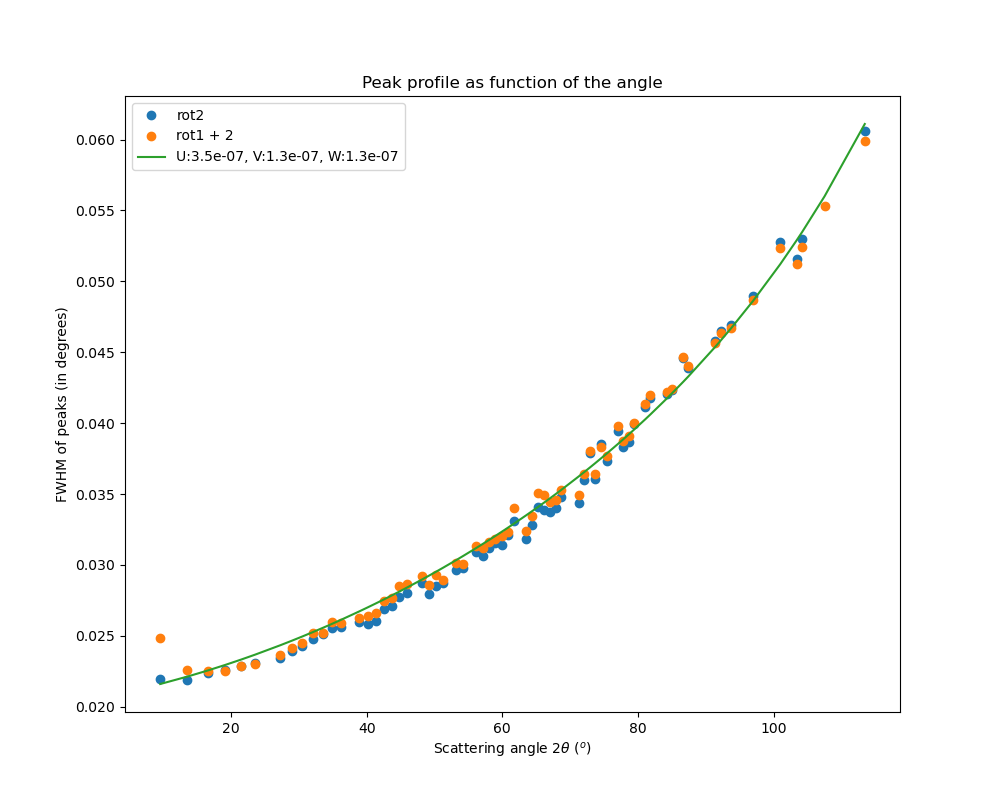

In [31]:
fig, ax = subplots(figsize=(10,8))
ax.plot(*calc_fwhm(res, width=(6,20), prominence=1.5e8), "o", label="rot2")
ax.plot(*calc_fwhm(res2, width=(6,20), prominence=1.5e8), "o", label="rot1 + 2")
# for lbl, sg in gonioref2d.single_geometries.items():
#     ai = gonioref2d.get_ai(sg.get_position())
#     img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
#     res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
#     t,w = calc_fwhm(res, calibrant=calibrant)
#     ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak profile as function of the angle")
ax.set_ylabel("FWHM of peaks (in degrees)")
ax.set_xlabel(res.unit.label)
ax.plot(tth_deg, model_Caglioti(tth_deg, *fit), label="U:%.1e, V:%.1e, W:%.1e"%(fit[0], fit[1], fit[2]))
ax.legend()
pass

In [32]:
print(f"Total execution time: {time.perf_counter() - start_time:.3f} s")

Total execution time: 49.636 s
